In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import json

In [2]:
import os
print(os.getcwd())

c:\Users\JANELLE_PRIME\System - E\storage\python_scripts


In [3]:
csv_file = "earthquake_data.csv"   
output_json = "earthquake_forecast.json"
output_img = "earthquake_forecast.png"

In [4]:
# --- Load CSV ---
df = pd.read_csv(csv_file)
df = df[df['Date'].str.match(r'^\d{4}-\d{2}$')]  # Keep only YYYY-MM
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# --- Aggregate to yearly totals ---
df_yearly = df['total_earthquakes'].resample('YE').sum().to_frame()
df_yearly['Year'] = df_yearly.index.year

# Reset index for Linear Regression
df_reset = df_yearly.reset_index(drop=True)
df_reset['YearNumber'] = np.arange(len(df_reset))  # for linear trend


In [5]:
# --- Linear Regression ---
X = df_reset['YearNumber'].values.reshape(-1, 1)
y = df_reset['total_earthquakes'].values
lin_model = LinearRegression()
lin_model.fit(X, y)

# Predict next 5 years
future_steps = 5
future_year_numbers = np.arange(len(df_reset), len(df_reset) + future_steps).reshape(-1, 1)
forecast_linear = lin_model.predict(future_year_numbers)


In [6]:
# --- Function for Moving Average Forecast ---
def moving_average_forecast(series, window, steps):
    forecast = []
    series_extended = list(series)
    for _ in range(steps):
        ma_value = np.mean(series_extended[-window:])
        forecast.append(ma_value)
        series_extended.append(ma_value)
    return forecast

# Compute MA_3 and MA_5 forecasts for next 5 years
forecast_ma3 = moving_average_forecast(df_reset['total_earthquakes'], window=3, steps=future_steps)
forecast_ma5 = moving_average_forecast(df_reset['total_earthquakes'], window=5, steps=future_steps)

# Also compute rolling columns for reference
df_reset['MA_3'] = df_reset['total_earthquakes'].rolling(window=3).mean()
df_reset['MA_5'] = df_reset['total_earthquakes'].rolling(window=5).mean()


In [7]:
# Future year labels
last_year = df_reset['Year'].iloc[-1]
future_years = [last_year + i for i in range(1, future_steps + 1)]

forecast_df = pd.DataFrame({
    'Year': future_years,
    'Linear_Trend_Forecast': forecast_linear,
    'MA_3_Forecast': forecast_ma3,
    'MA_5_Forecast': forecast_ma5
})

# Save to JSON
forecast_json = forecast_df.to_dict(orient='records')
with open(output_json, 'w') as f:
    json.dump(forecast_json, f, indent=4, default=str)

# Display in notebook
forecast_df


,Year,Linear_Trend_Forecast,MA_3_Forecast,MA_5_Forecast
0,2025,16.0,19.000000,19.0
1,2026,14.5,17.333333,19.0
2,2027,13.0,19.111111,19.0
3,2028,11.5,18.481481,18.0
4,2029,10.0,18.308642,19.2


In [8]:
forecast = pd.read_json(file_path)
print(forecast.head())

NameError: name 'file_path' is not defined

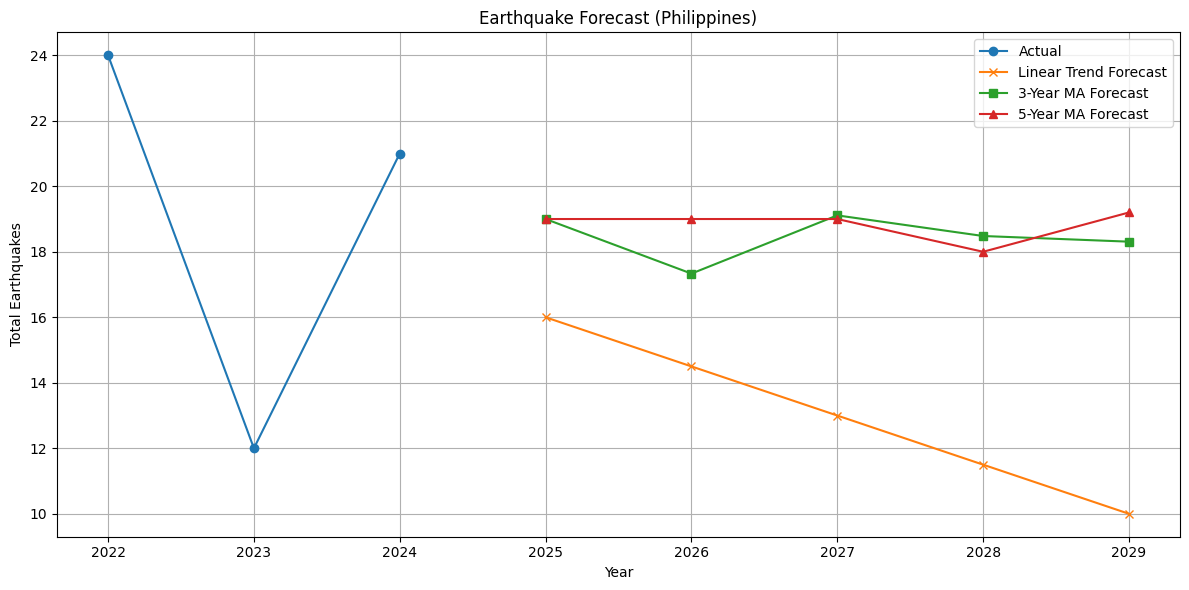

In [9]:
plt.figure(figsize=(12, 6))

# Historical data
plt.plot(df_reset['Year'], df_reset['total_earthquakes'], label='Actual', marker='o')

# Forecasts
plt.plot(future_years, forecast_linear, label='Linear Trend Forecast', marker='x')
plt.plot(future_years, forecast_ma3, label='3-Year MA Forecast', marker='s')
plt.plot(future_years, forecast_ma5, label='5-Year MA Forecast', marker='^')

plt.title('Earthquake Forecast (Philippines)')
plt.xlabel('Year')
plt.ylabel('Total Earthquakes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(output_img)
plt.show()
plt.close()
